### Your name:

<pre> Zahir Mohammed Mandsaurwala</pre>

### Collaborators:

<pre> None</pre>


# Assignment for Module 8: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


In [1]:
# Common imports
import numpy as np
import pandas as pd

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.cluster import AgglomerativeClustering

import random
random.seed(42)

In [2]:
pathToFile = r"C:\\Users\\zmandsaurwal\\Downloads\\electricityloaddiagrams20112014\\"
fileName = 'LD2011_2014.txt'

## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

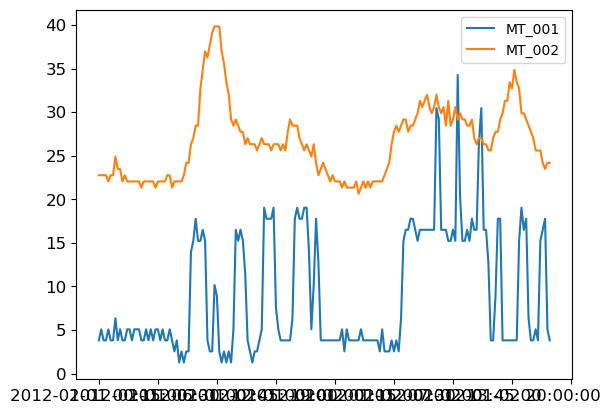

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = pd.concat([data2013, data2014]) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [19]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

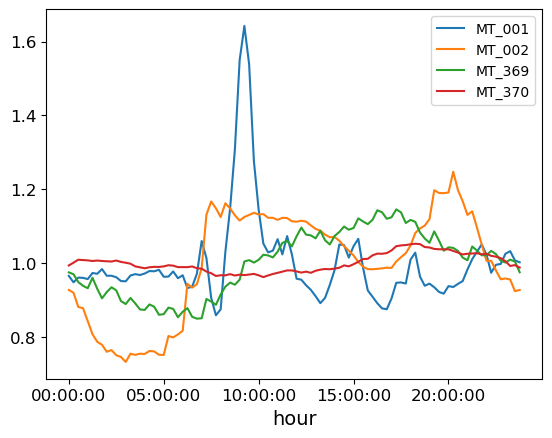

In [20]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [21]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it in the right format

## Exercise 1

a. Using the functions described in Module 8, determine a convenient number of clusters based on _inertia_ and based on _silhouette_. Justify your choice.

### 6 Clusters appear to be the most optimal solution. Its because...
##### 1.) Silhoutte score is highest (>0.425) at k=6
##### 2.) Intertia has an Elbow at k=6

b. Make a plot for each cluster that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

#### Plotting Inertia for a range of K-clusters

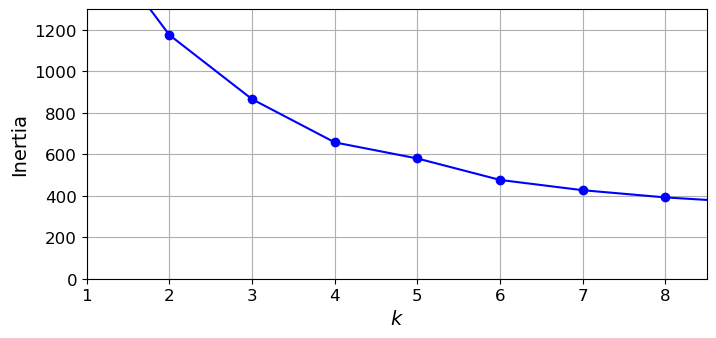

In [22]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

#### Plotting silhouette for a range of K-clusters

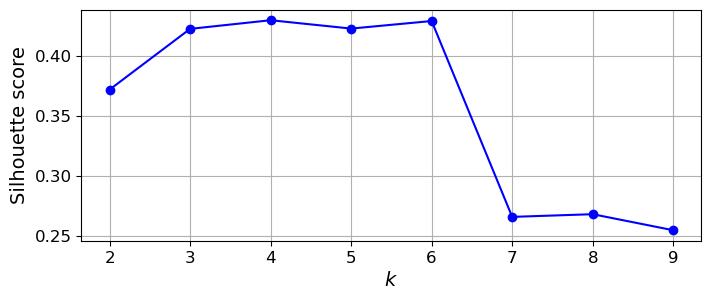

In [23]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

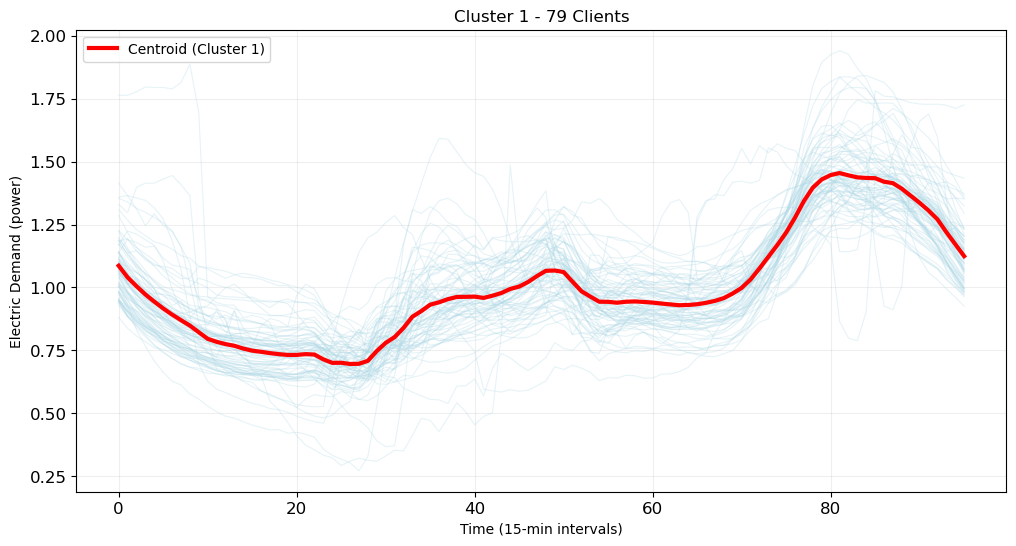

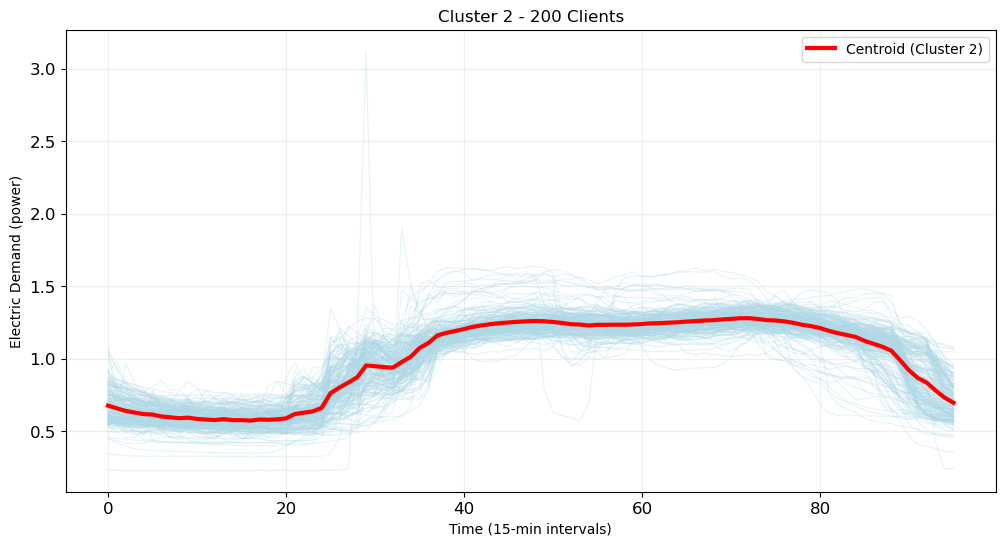

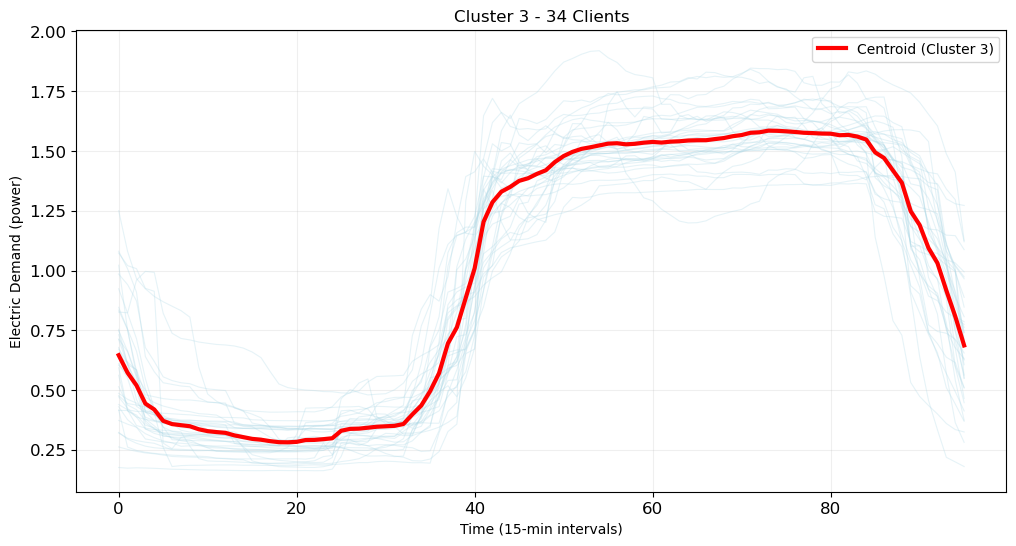

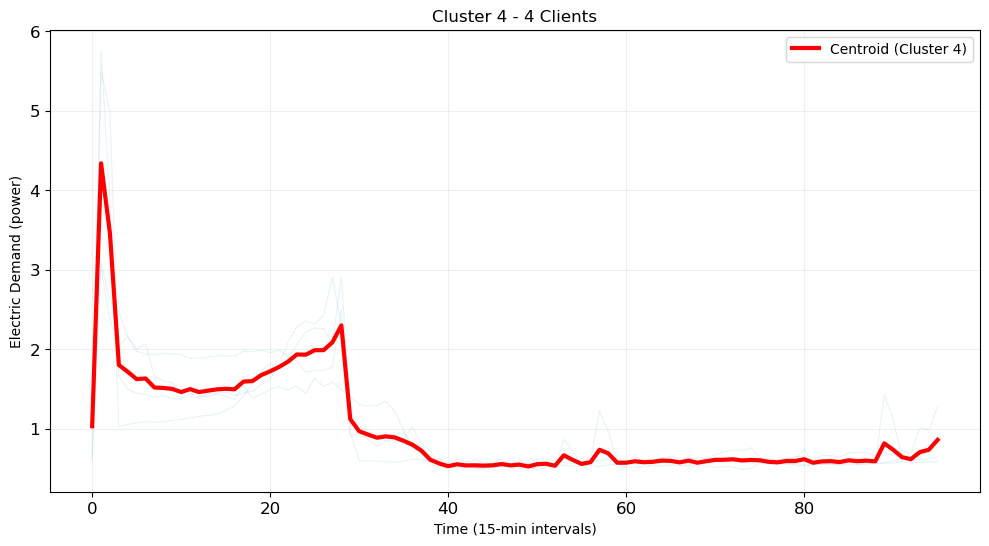

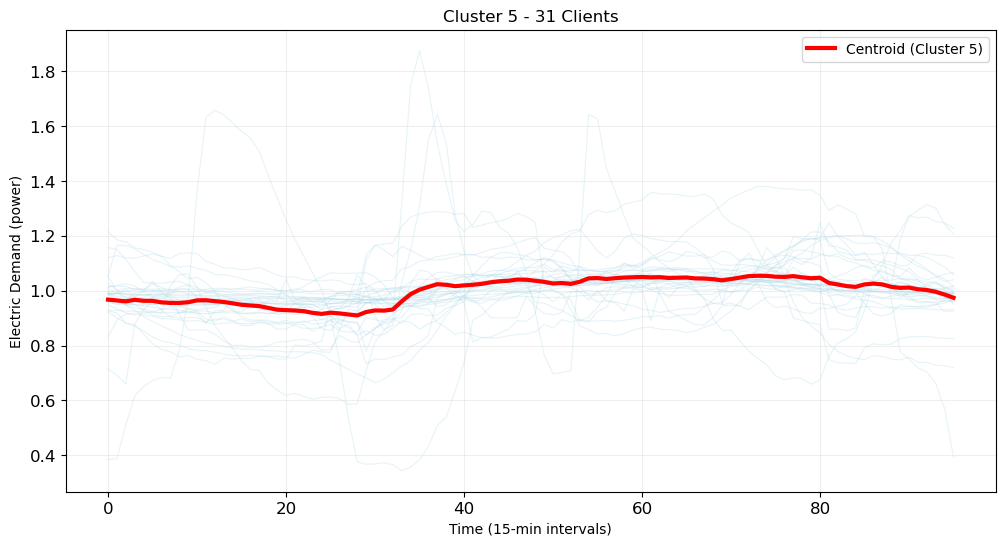

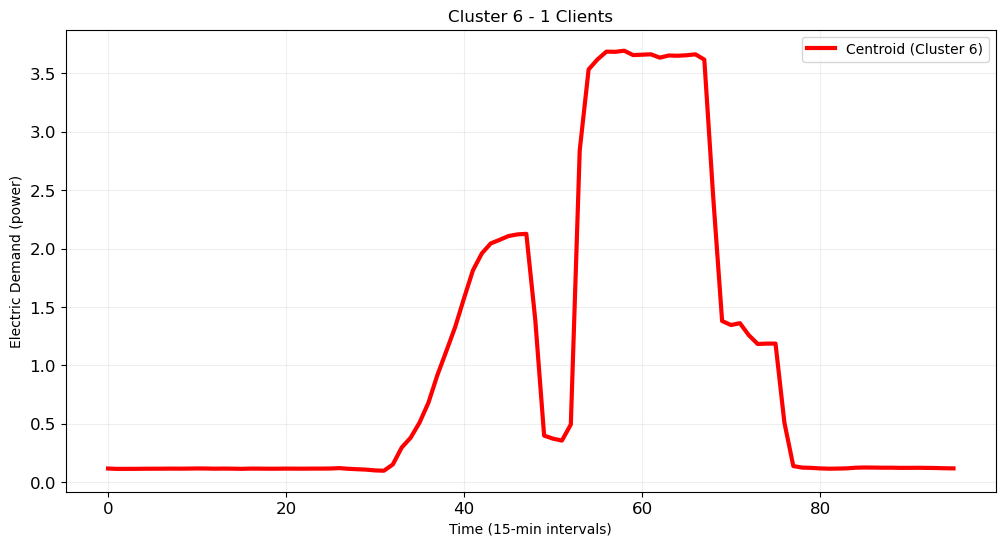

In [24]:
# Perform final clustering with optimal k
optimal_k = 6
final_kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
final_labels = final_kmeans.fit_predict(X)
centroids = final_kmeans.cluster_centers_

for i in range(optimal_k):
    cluster_curves = X[final_labels == i]
    
    plt.figure(figsize=(12, 6))
    
    # Individual curves
    for curve in cluster_curves:
        plt.plot(curve, color='lightblue', alpha=0.3, linewidth=0.8)
    
    # Centroid
    plt.plot(centroids[i], color='red', linewidth=3, label=f'Centroid (Cluster {i+1})')
    
    # Formatting
    n_clients = len(cluster_curves)
    plt.title(f'Cluster {i+1} - {n_clients} Clients', fontsize=12)
    plt.xlabel('Time (15-min intervals)', fontsize=10)
    plt.ylabel('Electric Demand (power)', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.show()

## Exercise 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 
#### The optimal number of clusters are 2 as seen below.

b. What do the clusters that you obtained represent?
#### Cluster 1 reprsents the consumption in the Weekday (Mon-Fri) and Cluster 2 represents weekend (Sat-Sun) consumption

In [25]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### Plotting Inertia for a range of K-clusters

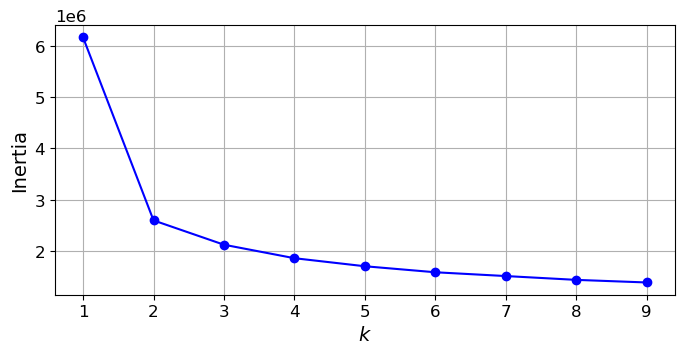

In [26]:
kmeans_cl_1_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_cl_1_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

#### Plotting silhouette for a range of K-clusters

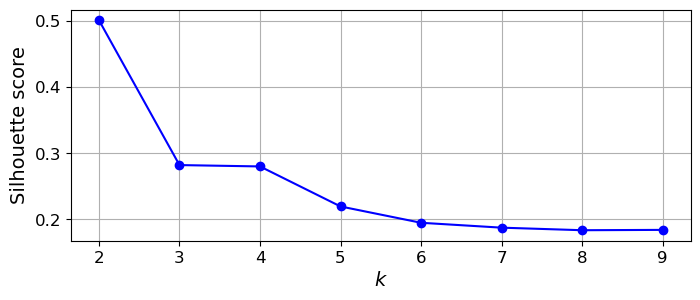

In [27]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_cl_1_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [28]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [29]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

In [30]:
kmeans_mt_022 = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans_mt_022.fit_predict(X)
centroids = kmeans_mt_022.cluster_centers_

#### Plotting Cluster patterns

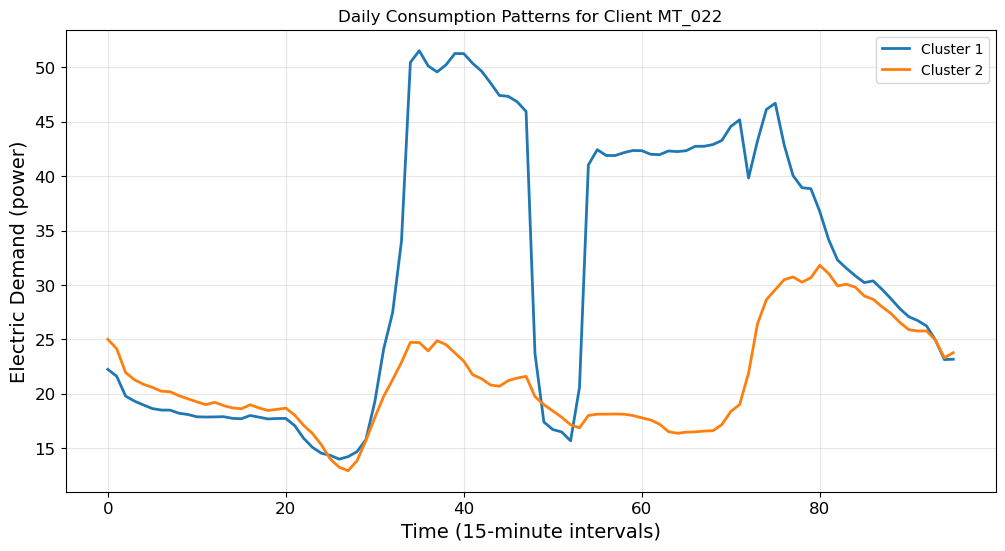

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(centroids[0], label='Cluster 1', linewidth=2)
plt.plot(centroids[1], label='Cluster 2', linewidth=2)
plt.title('Daily Consumption Patterns for Client MT_022')
plt.xlabel('Time (15-minute intervals)')
plt.ylabel('Electric Demand (power)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Plotting Bar graphs for each day to see the consumption on each day

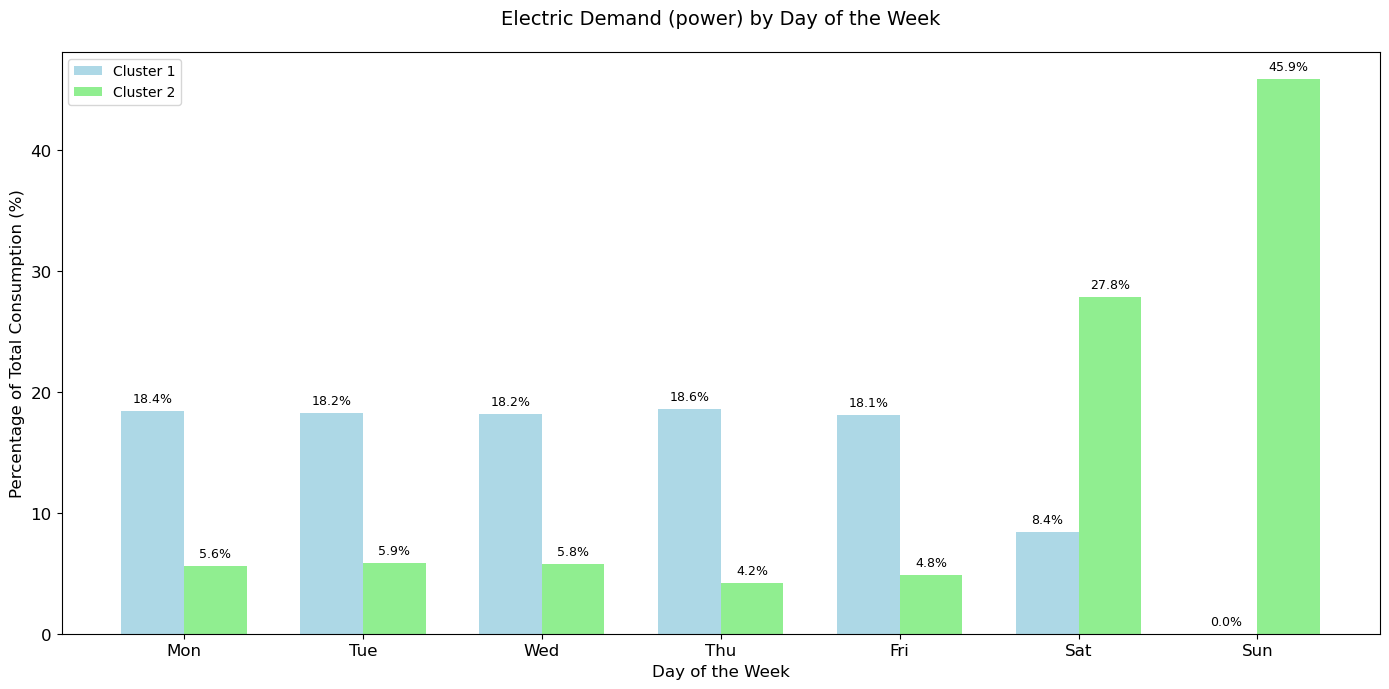

In [32]:
d1 = date(2013, 1, 1)
d2 = date(2014, 12, 31)
delta = d2 - d1
days_of_week = [(d1 + timedelta(days=i)).weekday() for i in range(delta.days + 1)]  # 0=Monday

# consumption by day of the week for each cluster
cluster_consumption = {0: [0]*7, 1: [0]*7}  # [Mon - Sun]
for idx, (label, day_idx) in enumerate(zip(labels, days_of_week)):
    daily_consumption = sum(X[idx])
    cluster_consumption[label][day_idx] += daily_consumption

for cluster in [0, 1]:
    total = sum(cluster_consumption[cluster])
    cluster_consumption[cluster] = [val/total*100 for val in cluster_consumption[cluster]]

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
x = np.arange(len(day_names))
width = 0.35

plt.figure(figsize=(14, 7))
bars1 = plt.bar(x - width/2, cluster_consumption[0], width, label='Cluster 1', color='lightblue')
bars2 = plt.bar(x + width/2, cluster_consumption[1], width, label='Cluster 2', color='lightgreen')

plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Percentage of Total Consumption (%)', fontsize=12)
plt.title('Electric Demand (power) by Day of the Week', fontsize=14, pad=20)
plt.xticks(x, day_names)
plt.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height+0.5,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

### Agglomerative Clustering

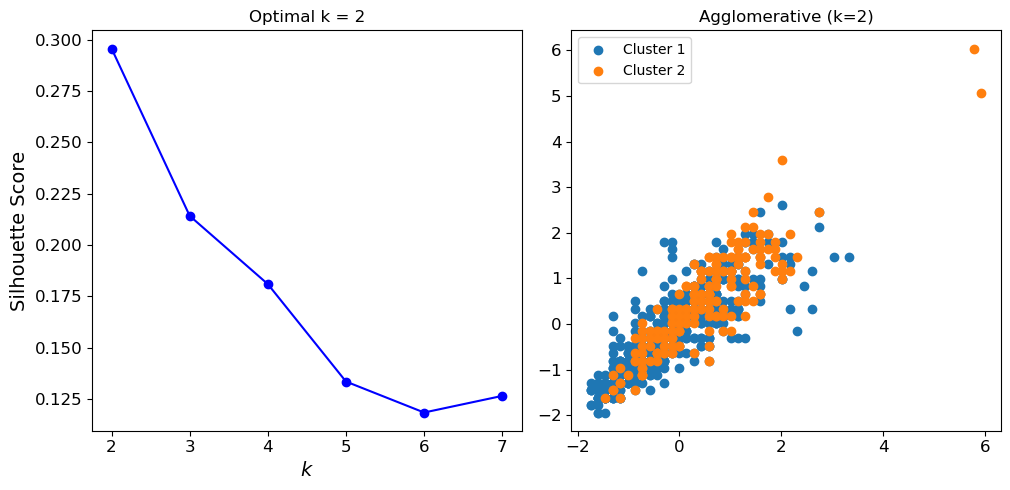

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 8)
silhouette_scores = []

for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

optimal_k = k_range[np.argmax(silhouette_scores)]

plt.figure(figsize=(15, 5))

# Plotting silhouette for a range of K-clusters
plt.subplot(131)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel("$k$")
plt.ylabel('Silhouette Score')
plt.title(f'Optimal k = {optimal_k}')

# Final clustering with optimal k
plt.subplot(132)
agg = AgglomerativeClustering(n_clusters=optimal_k)
labels = agg.fit_predict(X_scaled)

# Plot Clusters
for i in range(optimal_k):
    plt.scatter(X_scaled[labels == i, 0], X_scaled[labels == i, 1], 
                label=f'Cluster {i+1}')
plt.title(f'Agglomerative (k={optimal_k})')
plt.legend()
plt.tight_layout()
plt.show()


### K++ means clustering

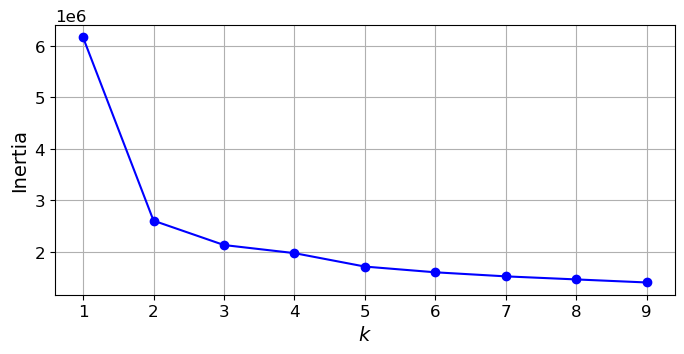

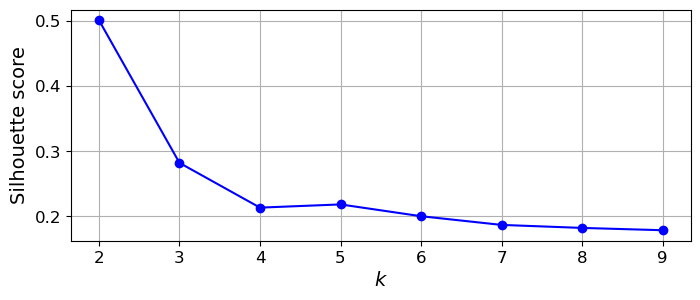

In [34]:
kmeans_plus_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_plus_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid()
plt.show()

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_plus_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()
